In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [3]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## EDA

reference: https://www.kaggle.com/code/tanmay111999/telco-churn-eda-cv-score-85-f1-score-80

* Simplified version with more precise analysis

### Quick inspection of data

7043 rows / observations, 21 columns / variables

In [4]:
data.shape

(7043, 21)

In [5]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


No obvious missing values.

* However, there are some spaces " " which will be discussed.

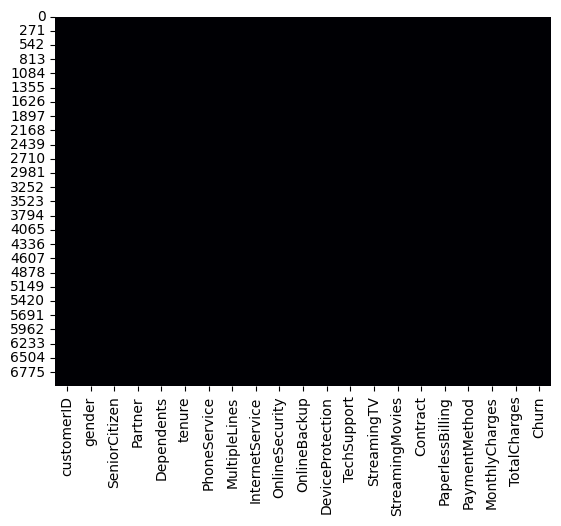

In [6]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

`TotalCharges` appears to be wrongly categorized as non-numeric
* This is caused by several values contains ' ' - To confirm, uncomment and run the cell below.
* As the number is small (11), we decide to drop these rows.

In [128]:
# original_values = data['TotalCharges'].copy()
# data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# # Capture exception row values
# print(original_values[data['TotalCharges'].isna()])

In [7]:
data.select_dtypes(include='object').head(2)

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5,No


In [8]:
print(data['TotalCharges'].iloc[[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]])

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object


In [10]:
indices_to_drop = [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

# Drop the specified rows
data = data.drop(indices_to_drop)

# Reset the index if needed
data = data.reset_index(drop=True)

In [ ]:
# convert to float
data['TotalCharges'] = data['TotalCharges'].astype(float)

Four numberical variables
* `SeniorCitizen`: appear to be a binary variable with significant imbalance.
* `tenure`: no obvious abnormal values though tenure of 72 is a bit strange
* `MonthlyCharges`: no obvious abnormal values
* `TotalCharges`: no obvious abnormal values, appear to skew to the right

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7021.00,0.16,0.37,0.00,0.00,0.00,0.00,1.00
tenure,7021.00,32.43,24.55,1.00,9.00,29.00,55.00,72.00
MonthlyCharges,7021.00,64.79,30.08,18.25,35.60,70.35,89.85,118.75
TotalCharges,7021.00,2284.32,2267.24,18.80,401.50,1398.25,3795.45,8684.80


In [14]:
data["SeniorCitizen"].value_counts()

SeniorCitizen
0    5881
1    1140
Name: count, dtype: int64

Drop column `customerID` as it appears to be totally random.

In [15]:
data.drop(columns = ['customerID'], inplace = True)

## Encode label columns to numberical values and inspect unique values

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df1 = data.copy(deep = True)
text_data_features = [i for i in list(data.columns) if i not in list(data.describe().columns)]

print('Label Encoder Transformation')
for i in text_data_features :
    df1[i] = le.fit_transform(df1[i])
    print(i,' : ',df1[i].unique(),' = ',le.inverse_transform(df1[i].unique()))

Label Encoder Transformation
gender  :  [0 1]  =  ['Female' 'Male']
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn  :  [0 1]  =  ['No' 'Yes']


Inspect distributions for all columns

In [17]:
df1.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00,7021.00
mean,0.50,0.16,0.48,0.30,32.43,0.90,0.94,0.87,0.79,0.91,0.90,0.80,0.98,0.99,0.69,0.59,1.57,64.79,2284.32,0.27
std,0.50,0.37,0.50,0.46,24.55,0.30,0.95,0.74,0.86,0.88,0.88,0.86,0.89,0.89,0.83,0.49,1.07,30.08,2267.24,0.44
min,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.25,18.80,0.00
25%,0.00,0.00,0.00,0.00,9.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,35.60,401.50,0.00
50%,1.00,0.00,0.00,0.00,29.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,2.00,70.35,1398.25,0.00
75%,1.00,0.00,1.00,1.00,55.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.00,89.85,3795.45,1.00
max,1.00,1.00,1.00,1.00,72.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,3.00,118.75,8684.80,1.00


### Visualization

Compare mean values for each explanatory variable between Group CHURN and Group NOT CHURN
* Almost no difference (no predictive power for churning): `gender`, `PhoneService`
* Close (weak predictive power): `MultipleLines`, `InternetService`, `StreamngTV`, `StreamingMoview`, `PaymentMethod`
* Larger difference: all other columns

(Clearly, the above comparisons did not take account of effect of variance, thus just preliminary inspection)

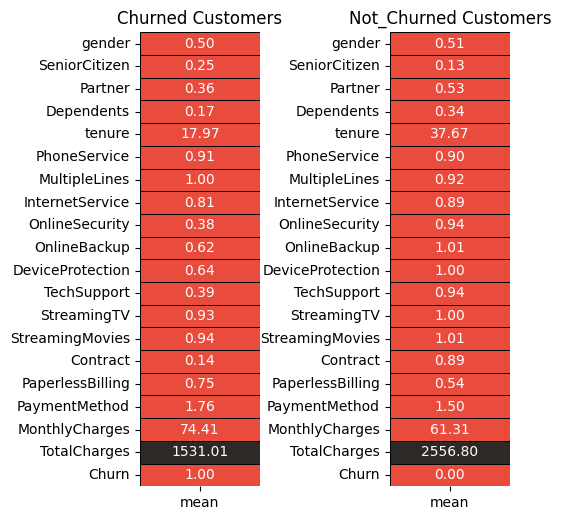

In [18]:
colors = ['#E94B3C','#2D2926']

churn = df1[df1['Churn'] == 1].describe().T
not_churn = df1[df1['Churn'] == 0].describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(churn[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Churned Customers');

plt.subplot(1,2,2)
sns.heatmap(not_churn[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Not_Churned Customers');

fig.tight_layout(pad = 0)

In [19]:
col = list(df1.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features:',*categorical_features)
print("-"*30)
print('Numerical Features:',*numerical_features)

Categorical Features: gender SeniorCitizen Partner Dependents PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies Contract PaperlessBilling PaymentMethod Churn
------------------------------
Numerical Features: tenure MonthlyCharges TotalCharges


#### Dependent variable Churn distribution

* Imbalanced though not severe: only about 1/4 is Churn while others are non-churn.

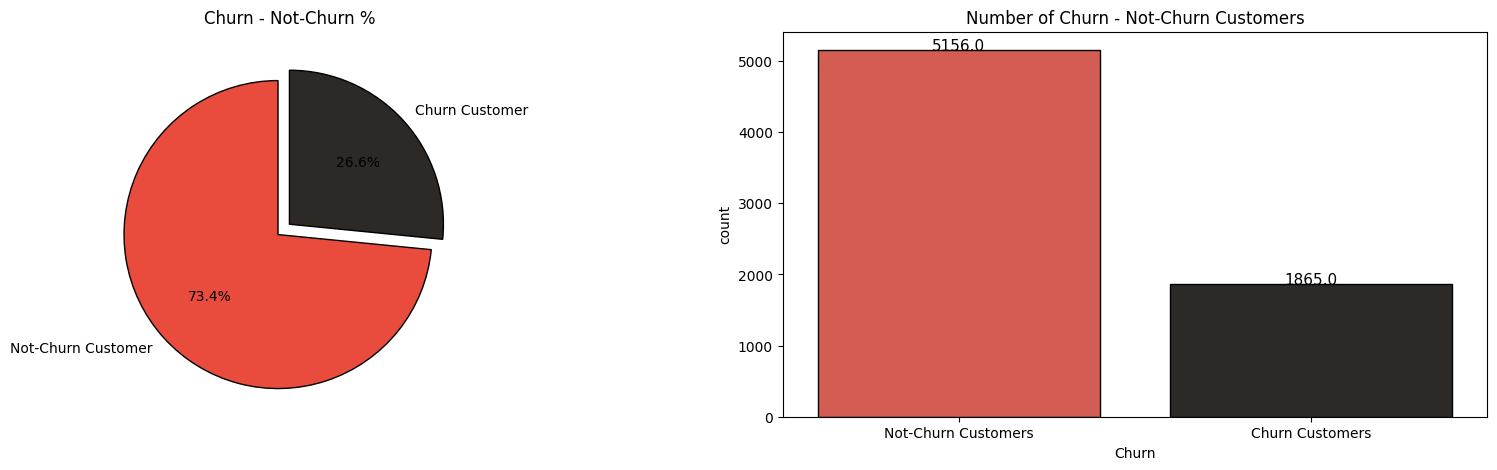

In [20]:
l = list(df1['Churn'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
plt.subplot(1,2,1)
plt.pie(circle,labels = ['Not-Churn Customer','Churn Customer'],autopct = '%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Churn - Not-Churn %');

plt.subplot(1,2,2)
ax = sns.countplot(x='Churn',data = data,palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
ax.set_xticklabels(['Not-Churn Customers','Churn Customers'])
    
plt.title('Number of Churn - Not-Churn Customers');
plt.show()

In [21]:
categorical_features.remove('Churn')

### Categorize variables by nature:
* Customer Information: `gender`, `SeniorCitizen`, `Partner`, `Dependents`
* Services Signed Up for: `PhoneService`, `MultipleLines`, `InternetService`, `StreamingTV`, `StreamingMovies`,
      `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`
* Payment Information: `Contract`, `PaperlessBilling`, `PaymentMethod`

In [23]:
l1 = ['gender','SeniorCitizen','Partner','Dependents'] # Customer Information
l2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!
l3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information

#### Effects of Customer Information

* `gender` probably has no predictive power for churning.
* Senior citizens are more likely to churn (a larger proportion of churning).
* Having partner is less likely to churn.
* Having dependents is less likely to churn.

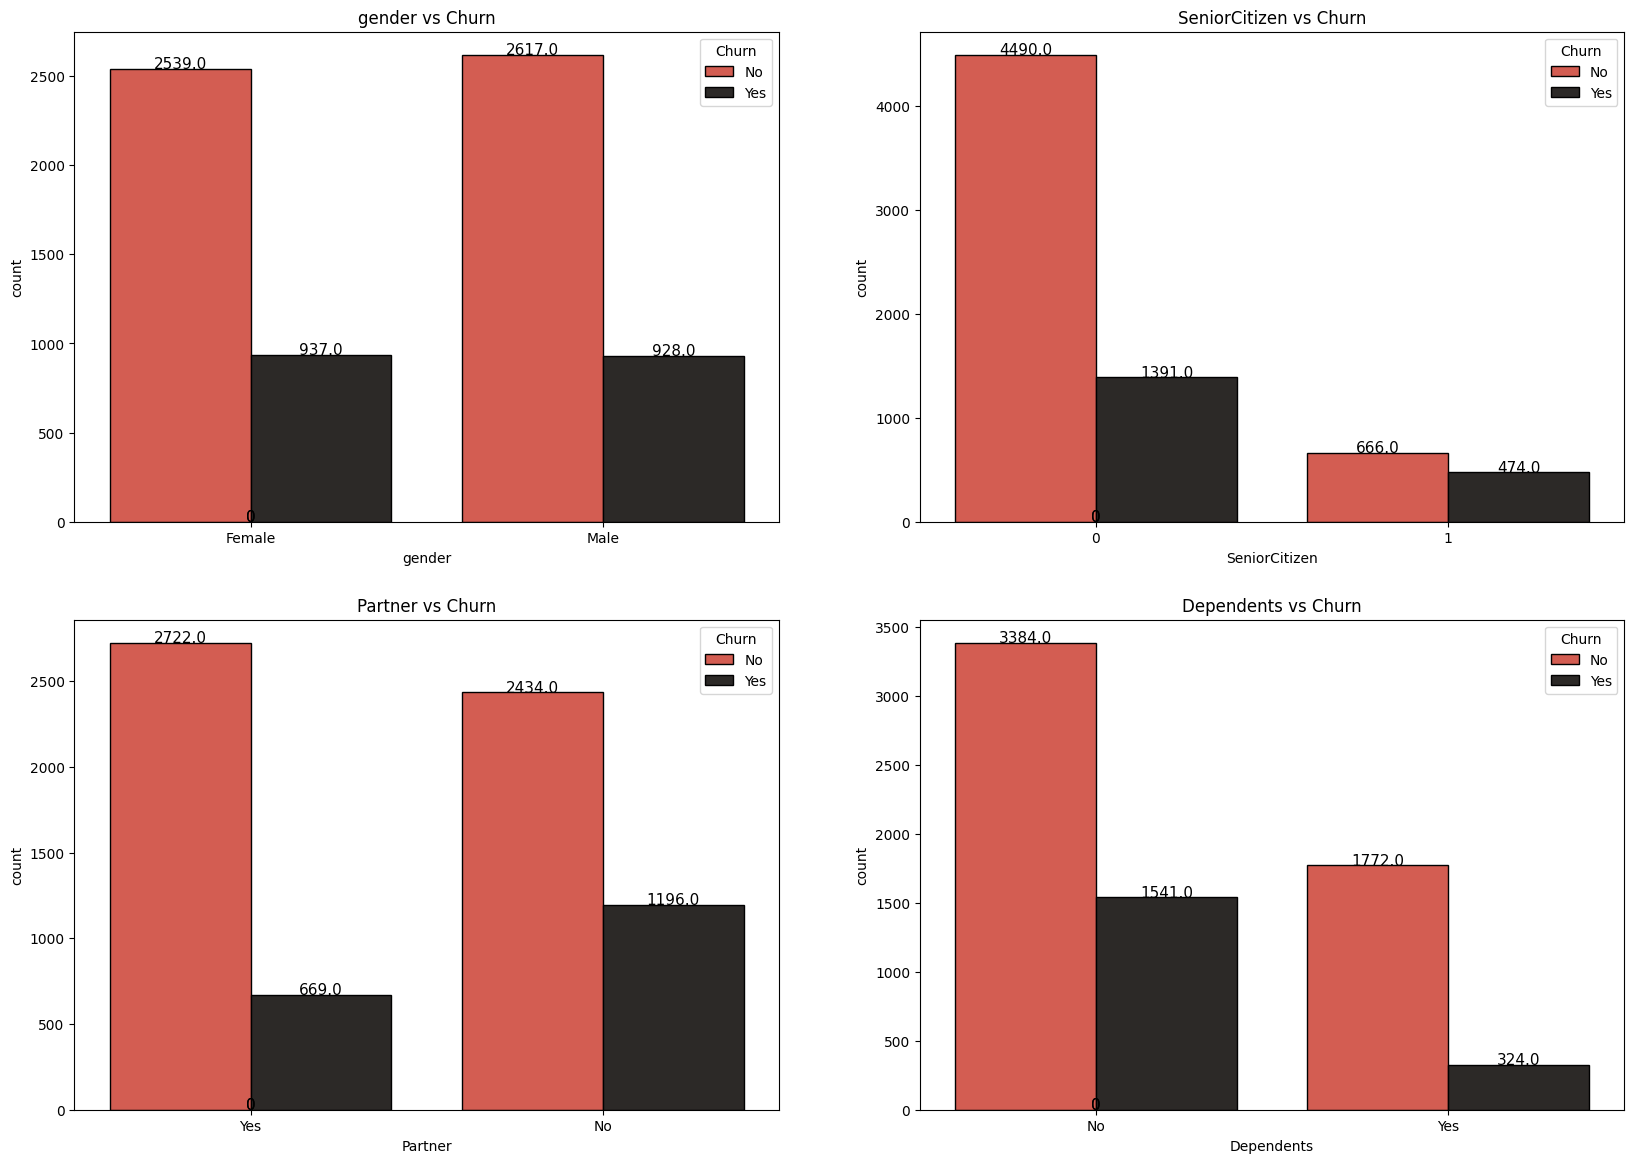

In [24]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l1)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(x=l1[i],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l1[i] + ' vs Churn'
    plt.title(title);

#### Effects of Services Signed Up for

* Having phone service is more likely to churn
* Having multiple lines appears to be slightly more likely to churn while the difference between no phone service and no multiple lines appears to be very small.
* Having internet service of fiber optic is a lot more likely to churn than others, while no internet serivice is least likely to churn.
* Similarly, no internet service is least likely to churn for StreamingTV and StreamingMovies, while no streaming service is slightly more likely to leave than ones without.

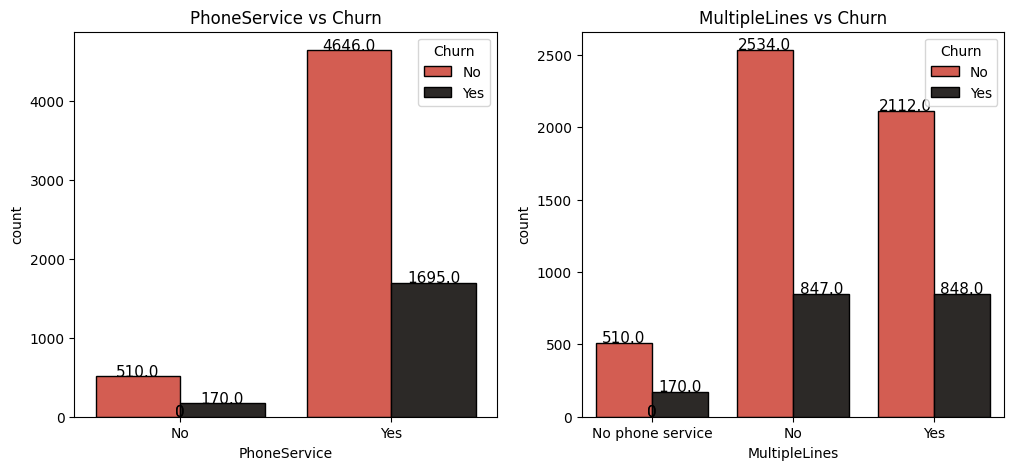

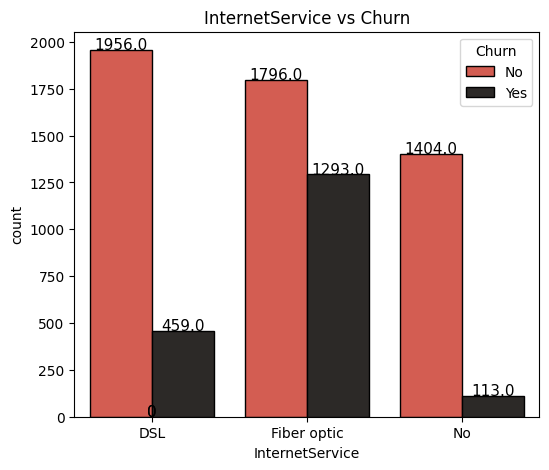

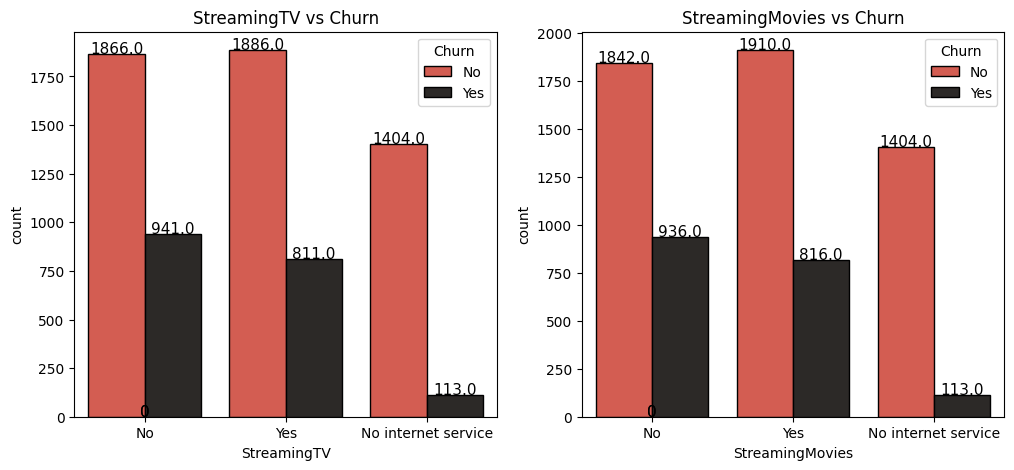

In [25]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(x=l2[i],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l2[i] + ' vs Churn'
    plt.title(title);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.countplot(x=l2[2],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l2[2] + ' vs Churn'
plt.title(title);
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(x=l2[i + 3],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l2[i + 3] + ' vs Churn'
    plt.title(title);

OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport exhibit similar effects.
* No > Yes > No internet service

('>' means more likely to churn)

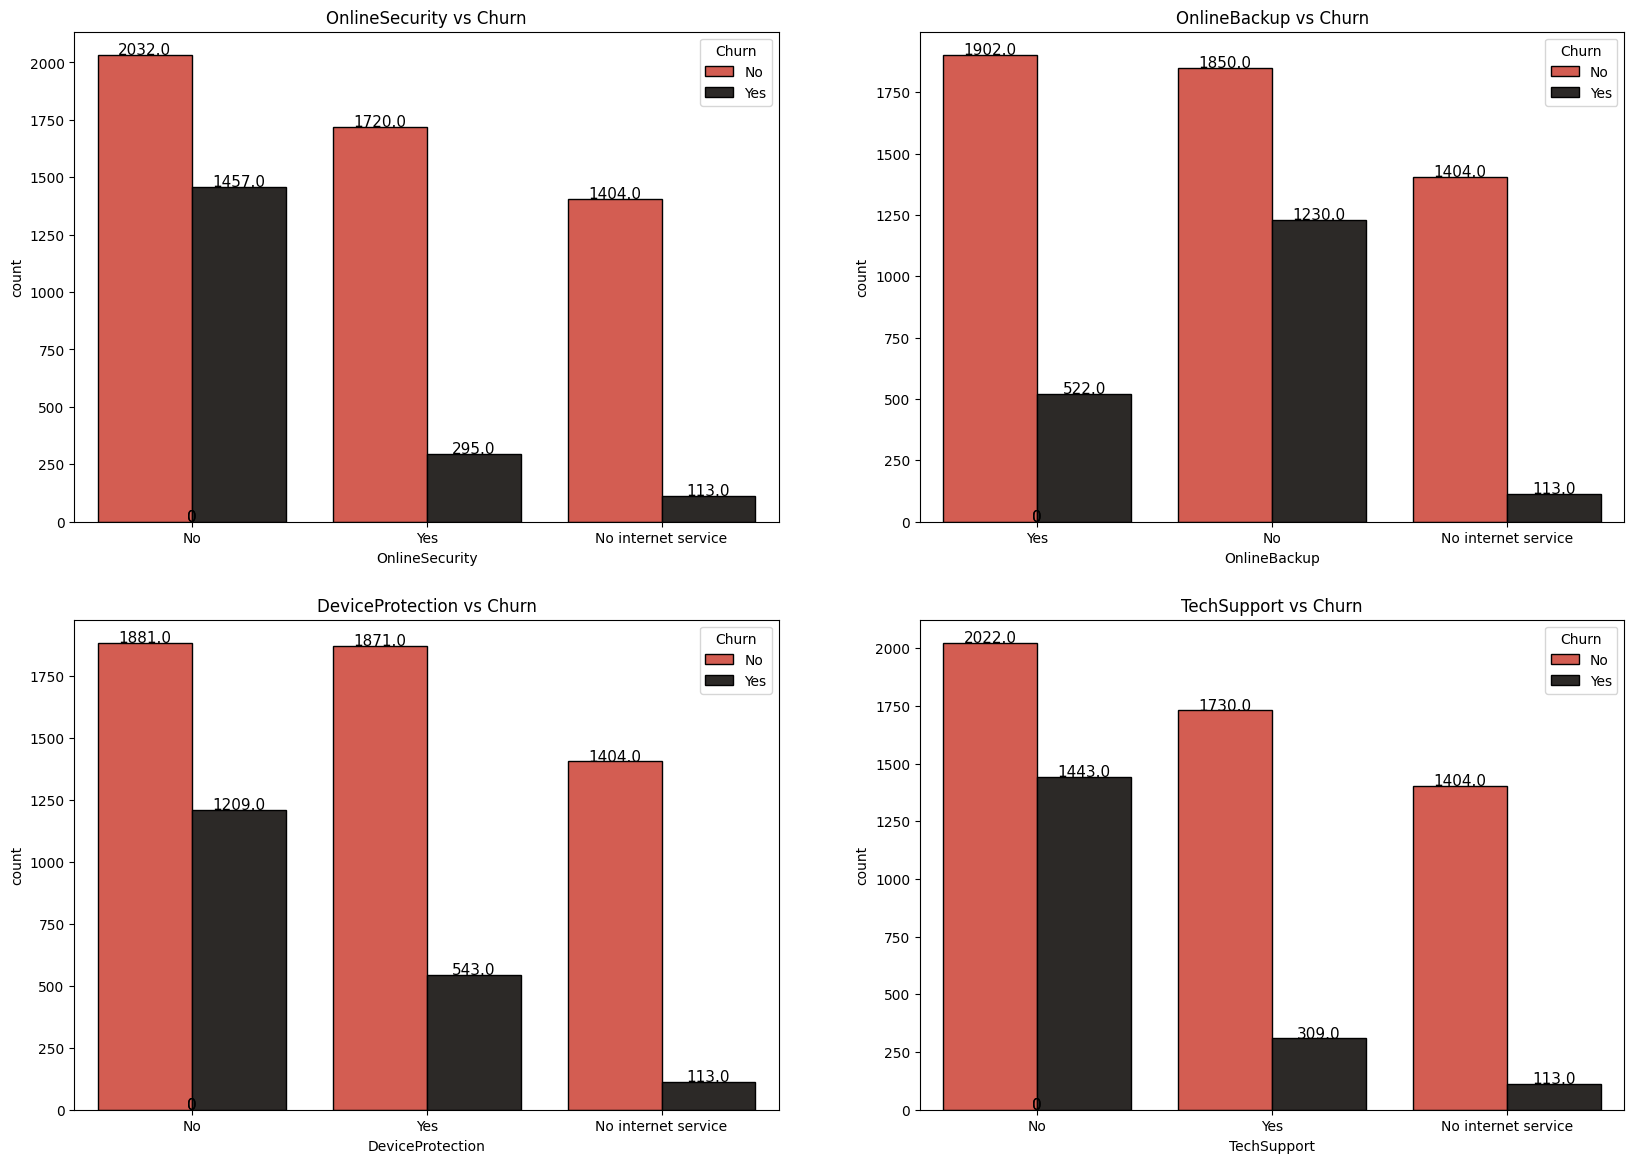

In [26]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.countplot(x=l2[-4 + i],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l2[-4 + i] + ' vs Churn'
    plt.title(title);

#### Payment Information
* Contract length: Month-to-month > one year contract > two year contract
* PaperlessBilling: Yes > No
* PaymentMethod: Electric check > Mailed > Bank transfer > Credit card

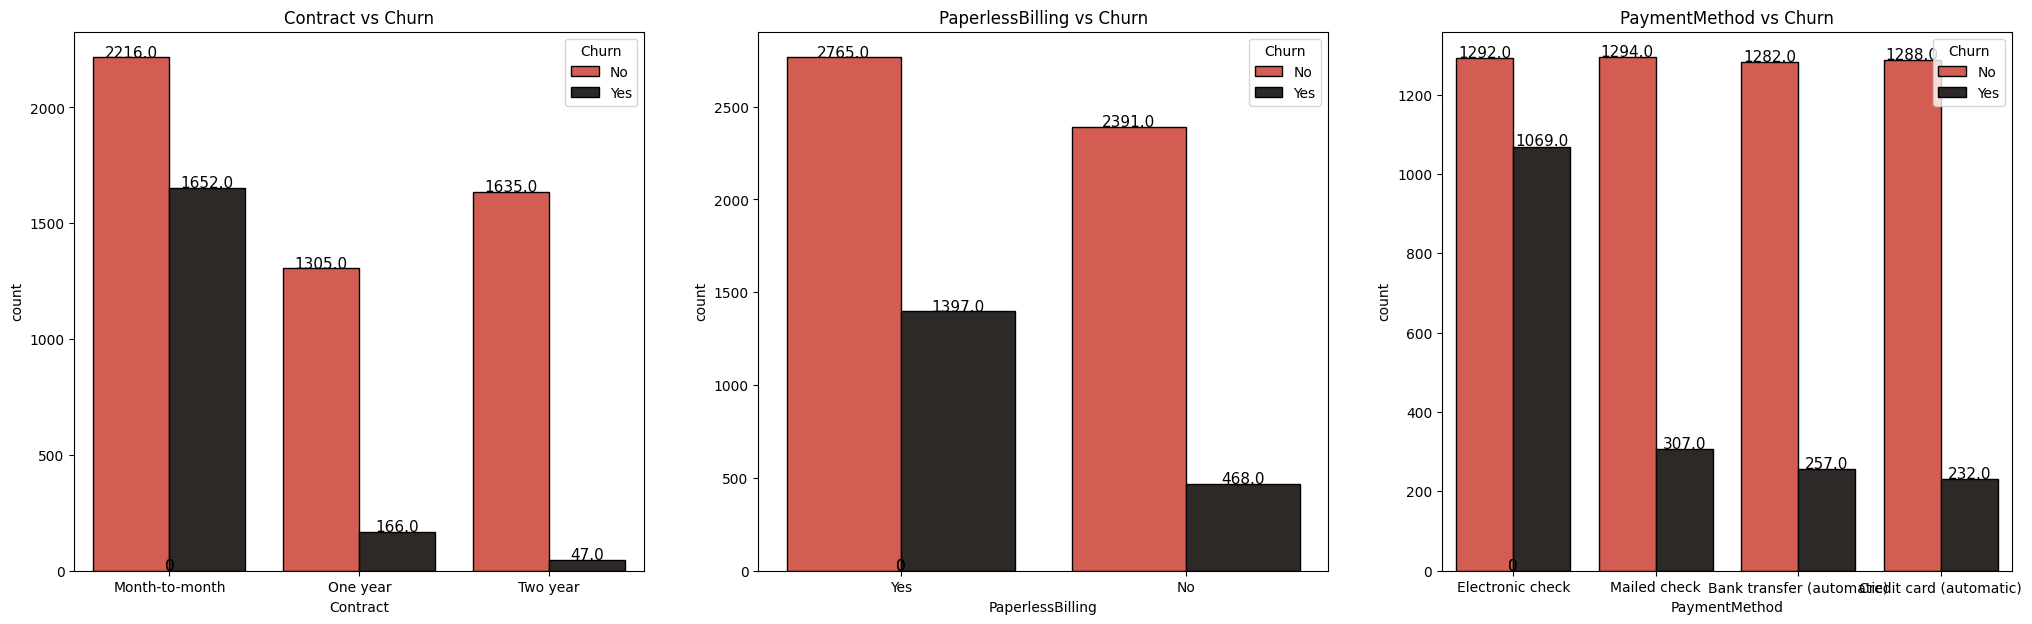

In [27]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

plt.subplot(1,3,1)
ax = sns.countplot(x=l3[0],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l3[0] + ' vs Churn'
plt.title(title);

plt.subplot(1,3,2)
ax = sns.countplot(x=l3[1],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l3[1] + ' vs Churn'
plt.title(title);

plt.subplot(1,3,3)
ax = sns.countplot(x=l3[2],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l3[2] + ' vs Churn'
plt.title(title);

### Numerical variables
* `tenure` and `MonthlyCharges` exhibit bipolar patern.
* `TotalCharge`sis skewed to the rightn.

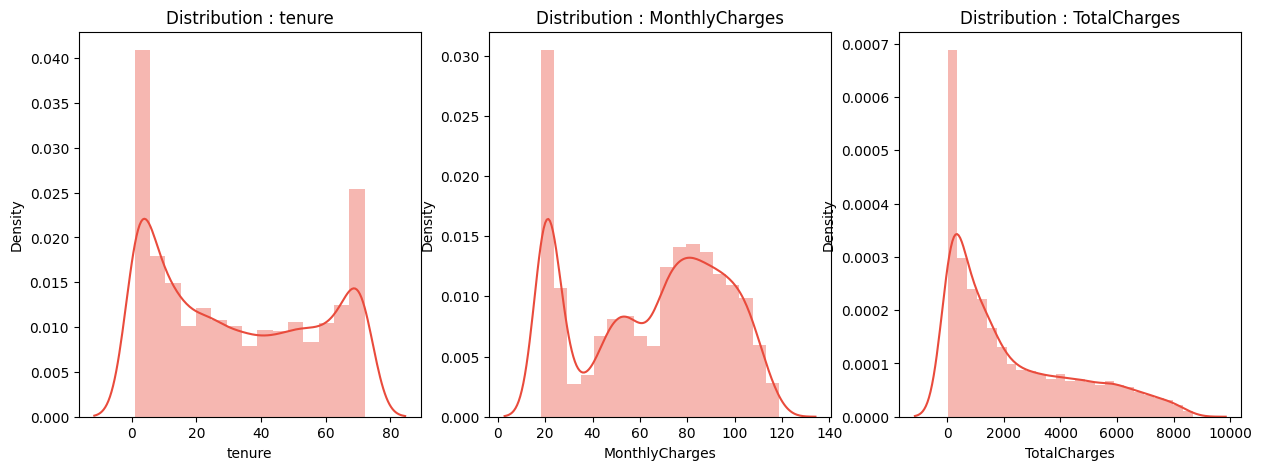

In [28]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(len(numerical_features)):
    plt.subplot(1,3,i+1)
    sns.distplot(df1[numerical_features[i]],color = colors[0])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

* `tenure`: churning rate decreases with tenure

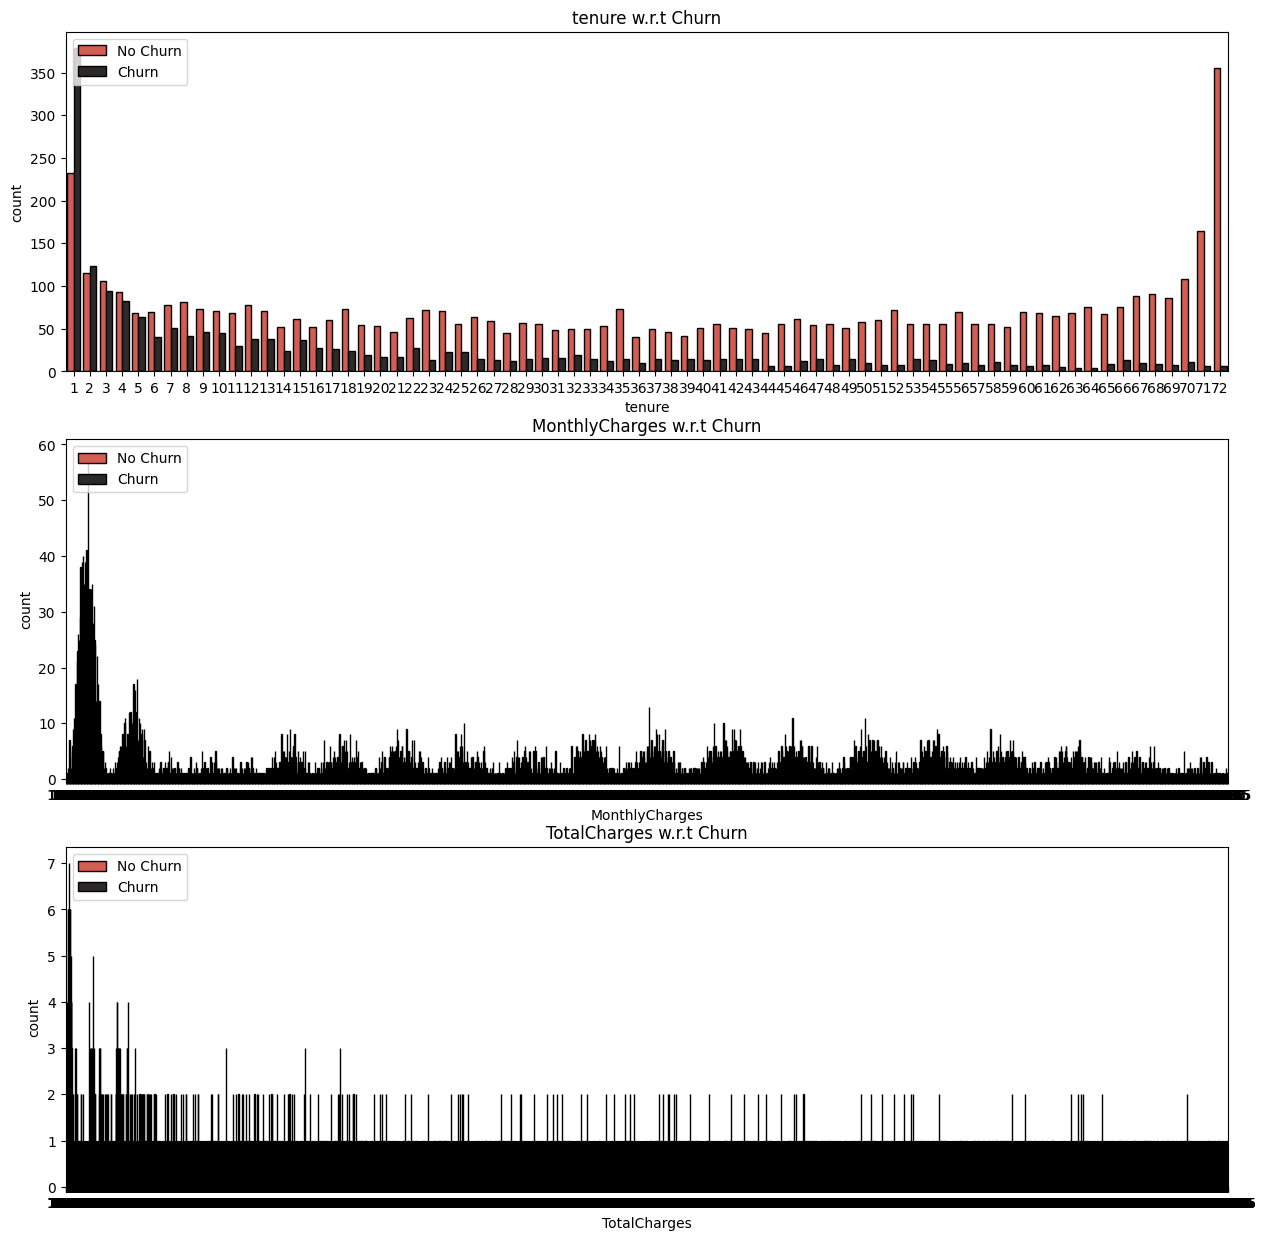

In [29]:
fig, ax = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,1,i+1)
    sns.countplot(x=numerical_features[i],data = df1,hue = "Churn",palette = colors,edgecolor = 'black')
    plt.legend(['No Churn','Churn'],loc = 'upper left')
    title = numerical_features[i] + ' w.r.t Churn'
    plt.title(title);

`MonthlyCharges` & `TotalCharges` are rescaled for understandable visualization and gaining insights purposes.

Here, we divide the data points of the numerical features by 5 or 500 and assign its quotient value as the representative constant for that data point. The scaling constants are decided by looking into the data & intuition

**Findings**
* The churning rate increases with `MonthlyCharges` then drops.
* The churning rate decreases with `TotalCharges`.

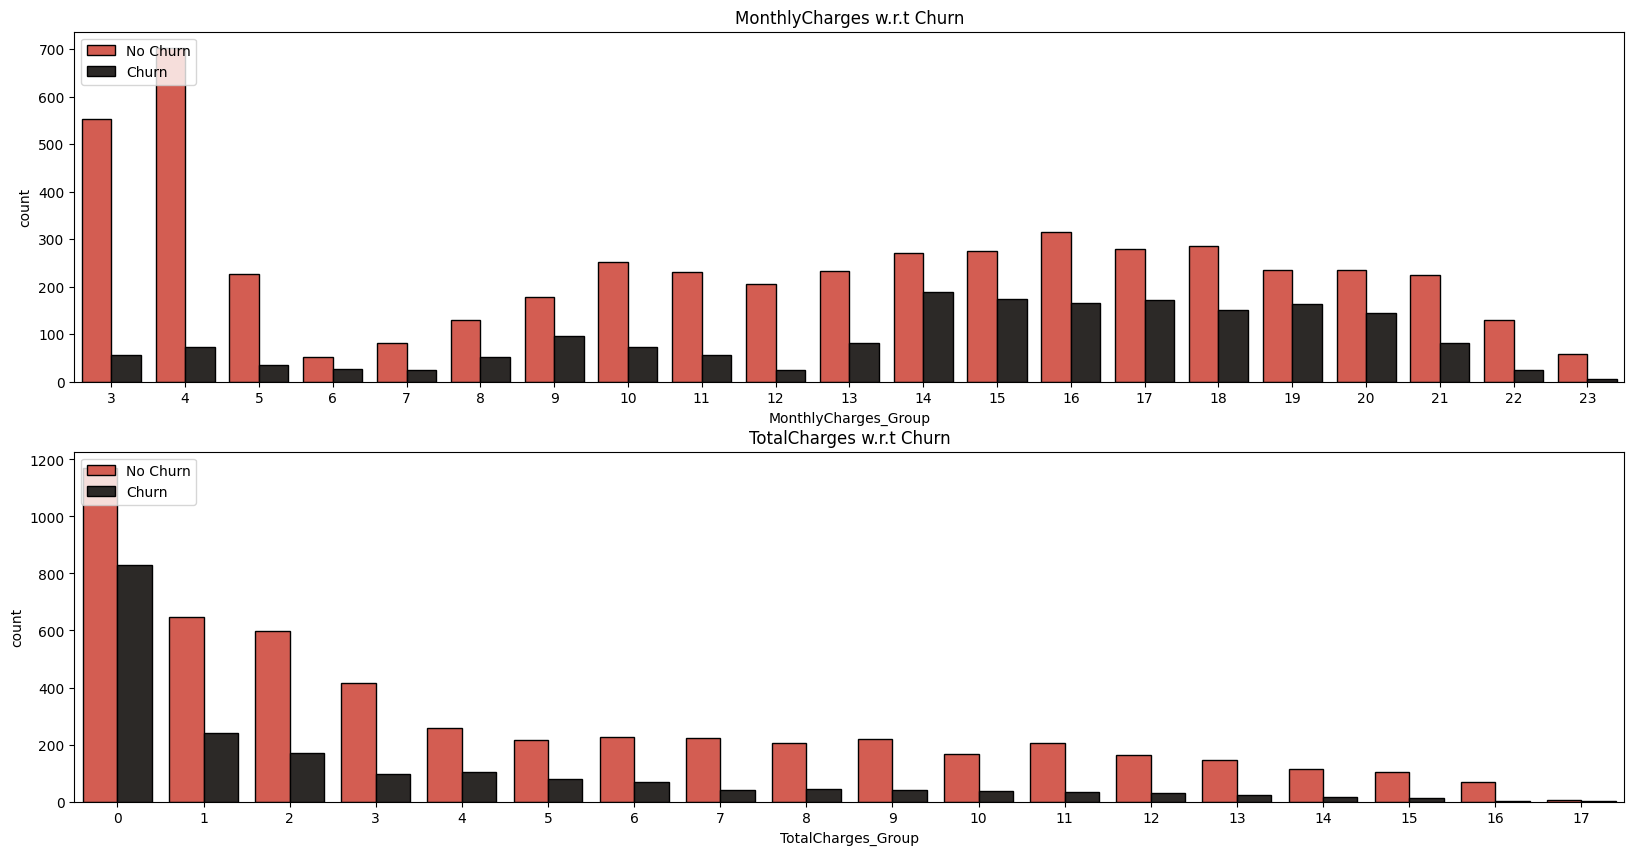

In [30]:
df1['MonthlyCharges_Group'] = [int(i / 5) for i in df1['MonthlyCharges']]
df1['TotalCharges_Group'] = [int(i / 500) for i in df1['TotalCharges']]

fig, ax = plt.subplots(nrows = 2,ncols = 1,figsize = (20,10))
for i in range(len(numerical_features[1:])):
    plt.subplot(2,1,i+1)
    sns.countplot(x=numerical_features[1 + i]+'_Group',data = df1,hue = "Churn",palette = colors,edgecolor = 'black')
    plt.legend(['No Churn','Churn'],loc = 'upper left')
    title = numerical_features[1 + i] + ' w.r.t Churn'
    plt.title(title);

In [31]:
# drop the two columns created for visualization purposes
df1.drop(columns = ['MonthlyCharges_Group','TotalCharges_Group'], inplace = True)

### Correlation matrix to measure the strength of linear relation between each variable and churning decision

* `MulipleLines`, `PhoneService`, `gender`, `StreamingTV`, `StreamingMovies` and `InternetService` does not display any kind of correlation. However they are actually categorical variables, so we keep them for now.
* 
Remaining features either display arelative largert positive or negative correlation.

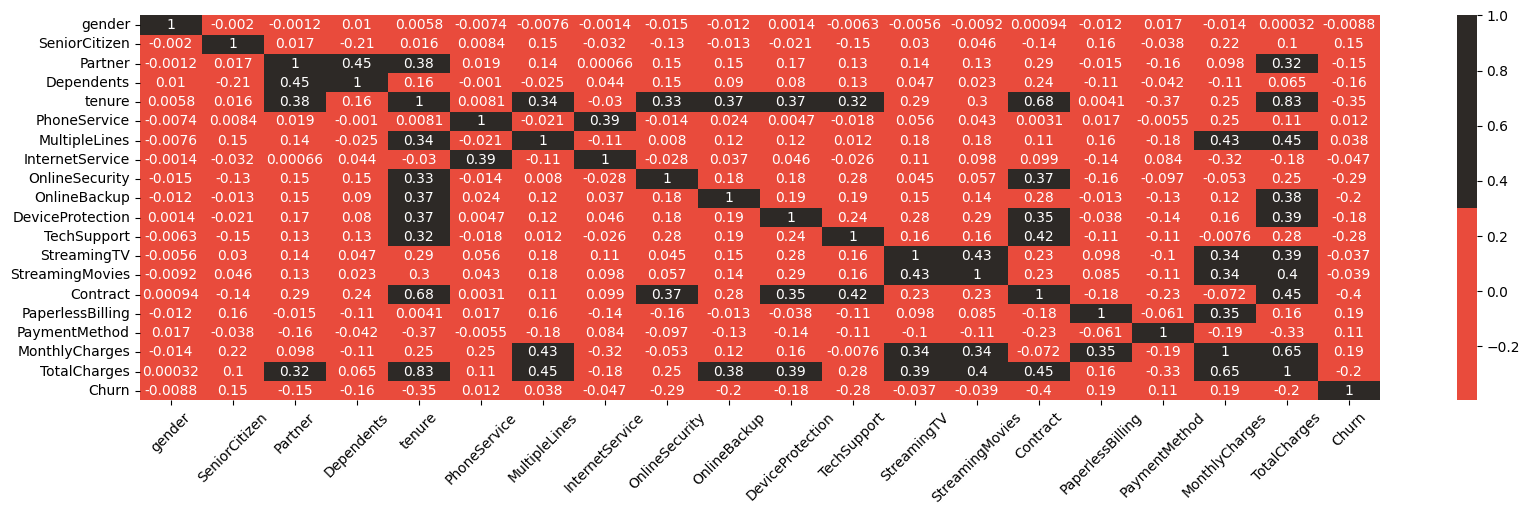

In [34]:
plt.figure(figsize = (20,5))
ax = sns.heatmap(df1.corr(),cmap = colors,annot = True)
ax.tick_params(axis='x', rotation=45)

Correlation with Churn only

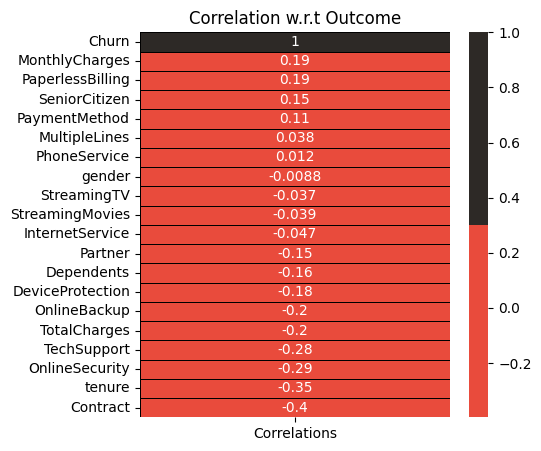

In [35]:
corr = df1.corrwith(df1['Churn']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t Outcome');

## Feature Engineering and Scaling

1. Feature Engineering: Create meaningful features that may help the model, such as calculating average monthly charges or segmenting customers by contract type.
2.	Encoding: Convert categorical variables into numerical formats.
3.	Scaling: Normalize or scale features as needed, especially when working with models sensitive to feature magnitude.


### Encoding

Encoding has been done earlier.

### Scaling

In [36]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1['tenure'] = mms.fit_transform(df1[['tenure']])
df1['MonthlyCharges'] = mms.fit_transform(df1[['MonthlyCharges']])
df1['TotalCharges'] = mms.fit_transform(df1[['TotalCharges']])

In [115]:
df1.head(2)

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0.00,0,2,0,0,0,1,2,0.12,0.00,0
1,0,0,0,0.46,2,0,2,0,1,0,3,0.39,0.22,0


### Feature Selection for Categorical Features using Chi-Squared Test

* Drop `MulipleLines`, `PhoneService`, `gender`, `StreamingTV`, `StreamingMovies` and `InternetService` because of low Chi-square scores.

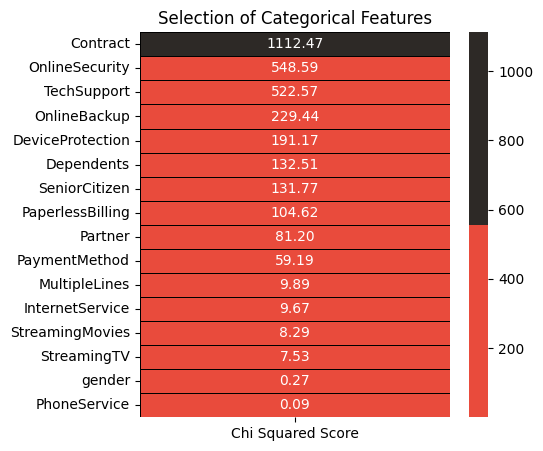

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif

features = df1.loc[:,categorical_features]
target = df1.loc[:,'Churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');

In [38]:
# drop irrelevant categorical columns
df1.drop(columns = ['MultipleLines','PhoneService', 'gender', 'StreamingTV', 'StreamingMovies', 'InternetService'], inplace = True)

In [39]:
categorical_features = []
numerical_features = []
for i in df1.columns:
    if i != "Churn":
        if len(df1[i].unique()) > 6:
            numerical_features.append(i)
        else:
            categorical_features.append(i)

### Feature Selection for Numerical Features using ANOVA

* Keep all numericals due to high ANOVA scores

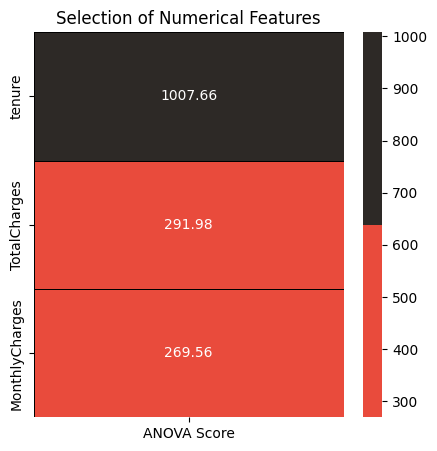

In [40]:
from sklearn.feature_selection import f_classif

features = df1.loc[:,numerical_features]
target = df1.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

## Deal with data imbalancing
* As Churn still accounts of over a quarter of data, we did not conduct data rebalancing.

## Model Building
1.	Train-Test Split: Split the data into training and testing sets to evaluate model performance.
2.	Model-1: You have to implement Neural networks (using Tensorflow/Pytorch/Keras) on this dataset.
3.	Model-2: You have to implement Convolutional Neural networks (CNNs) (using Tensorflow/PyTorch/Keras) on this dataset.
4.	Justify the choice of model based on the characteristics of the dataset and problem (i.e., which one performed better and wh
## Model Training and Evaluation
1.	Split the data into training and testing sets.
2.	Train the selected model(s) on the training data.
3.	Evaluate model performance on the testing data using metrics like accuracy, precision, recall, F1-score, and AUC (Area Under the ROC Curve).
4.	Deployment (Optional): If possible, deploy the trained model as a simple web application or API to demonstrate real-world applicability.y).


In [41]:
df1.head(3)

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0.00,0,2,0,0,0,1,2,0.12,0.00,0
1,0,0,0,0.46,2,0,2,0,1,0,3,0.39,0.22,0
2,0,0,0,0.01,2,2,0,0,0,1,3,0.35,0.01,1


In [42]:
y=df1.Churn.values
X = df1.drop('Churn', axis=1)

features = X.columns.values
X.columns = features
y=df1['Churn']

In [43]:
X.shape

(7021, 13)

### Split the data into training and testing sets.

In [44]:
from sklearn.model_selection import train_test_split

# First, split into train+val and test with stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then split train+val into train and validation with stratification
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

### Model-1: Neural Network

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [56]:
import tensorflow as tf
# Define the model
nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # Changed to sigmoid for binary classification
])

# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = nn.fit(X_train, y_train, 
                 validation_data=(X_val, y_val),
                 batch_size=64, 
                 epochs=50,
                 verbose=1)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7247 - loss: 0.5819 - val_accuracy: 0.7411 - val_loss: 0.5057
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7538 - loss: 0.4868 - val_accuracy: 0.7705 - val_loss: 0.4718
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7731 - loss: 0.4678 - val_accuracy: 0.7731 - val_loss: 0.4551
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7640 - loss: 0.4637 - val_accuracy: 0.7740 - val_loss: 0.4453
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7772 - loss: 0.4526 - val_accuracy: 0.7909 - val_loss: 0.4387
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7918 - loss: 0.4331 - val_accuracy: 0.7918 - val_loss: 0.4342
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7808 - loss: 0.4371 - val_accuracy: 0.8025 - val_loss: 0.4318
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7685 - loss: 0.4476 - val_accuracy: 0.7980 - val_loss:

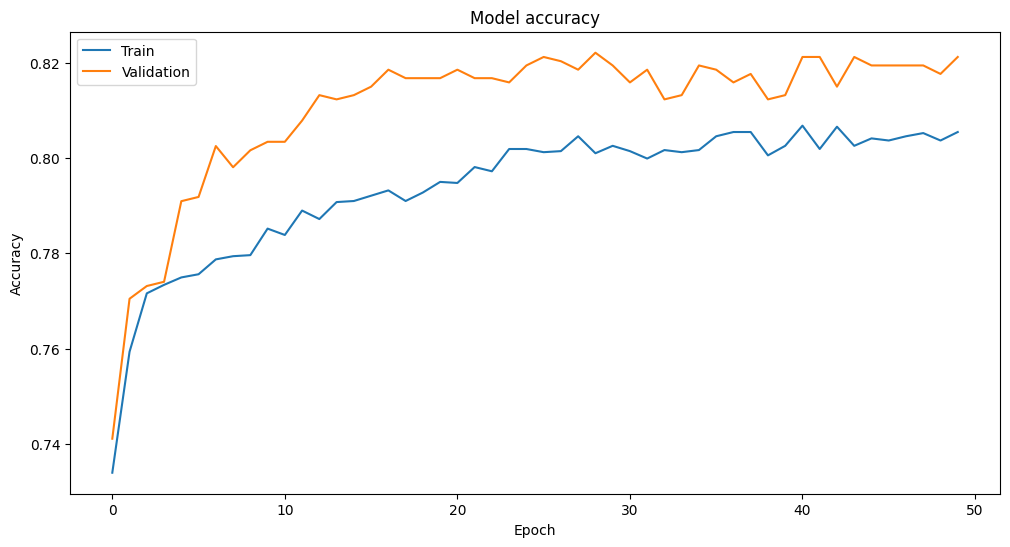

In [57]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Based on the training accuracy and validation accuracy, 28 epochs should be sufficient, thus we retrain the model with both training and validation data as training for 28 epochs.

In [58]:
nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # Changed to sigmoid for binary classification
])

# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = nn.fit(X_train_val, y_train_val, 
                 validation_data=(X_test, y_test),
                 batch_size=64, 
                 epochs=28,
                 verbose=1)

Epoch 1/28
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7270 - loss: 0.5243 - val_accuracy: 0.7317 - val_loss: 0.4884
Epoch 2/28
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7406 - loss: 0.4772 - val_accuracy: 0.7587 - val_loss: 0.4679
Epoch 3/28
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7649 - loss: 0.4641 - val_accuracy: 0.7680 - val_loss: 0.4570
Epoch 4/28
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.4446 - val_accuracy: 0.7715 - val_loss: 0.4526
Epoch 5/28
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7882 - loss: 0.4348 - val_accuracy: 0.7765 - val_loss: 0.4501
Epoch 6/28
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7891 - loss: 0.4387 - val_accuracy: 0.7815 - val_loss: 0.4499
Epoch 7/28
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7931 - loss: 0.4319 - val_accuracy: 0.7801 - val_loss: 0.4493
Epoch 8/28
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7858 - loss: 0.4288 - val_accuracy: 0.7786 - val_loss:

In [59]:
from sklearn import metrics

# Predict probabilities
y_pred_proba = nn.predict(X_test)
# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Print metrics
print("Neural Network Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Classification report
print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
conf_mat_df = pd.DataFrame(
    conf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"], 
    index=["Actual Negative", "Actual Positive"]
)
print('\nConfusion Matrix:')
print(conf_mat_df)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Metrics:
Accuracy: 0.7794
Precision: 0.6068
Recall: 0.4799
F1-score: 0.5359
AUC: 0.8160

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1032
           1       0.61      0.48      0.54       373

    accuracy                           0.78      1405
   macro avg       0.72      0.68      0.70      1405
weighted avg       0.77      0.78      0.77      1405


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 916                 116
Actual Positive                 194                 179


## Model-2: Convolutional Neural networks (CNNs) 

Reference: https://www.kaggle.com/code/jinankordab/churnprediction

In [60]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Initialize the model
model = Sequential()

# Add 1D Convolutional layers with ReLU activation
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))

# Flatten the tensor output by the convolutional layers
model.add(Flatten())

# Add Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7130 - loss: 0.5497 - val_accuracy: 0.7678 - val_loss: 0.4840
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7634 - loss: 0.4837 - val_accuracy: 0.7883 - val_loss: 0.4658
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7721 - loss: 0.4754 - val_accuracy: 0.7874 - val_loss: 0.4702
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7701 - loss: 0.4664 - val_accuracy: 0.7891 - val_loss: 0.4521
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7824 - loss: 0.4611 - val_accuracy: 0.7927 - val_loss: 0.4477
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7698 - loss: 0.4523 - val_accuracy: 0.7945 - val_loss: 0.4450
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7779 - loss: 0.4456 - val_accuracy: 0.7936 - val_loss: 0.4400
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7792 - loss: 0.4479 - val_accuracy: 0.

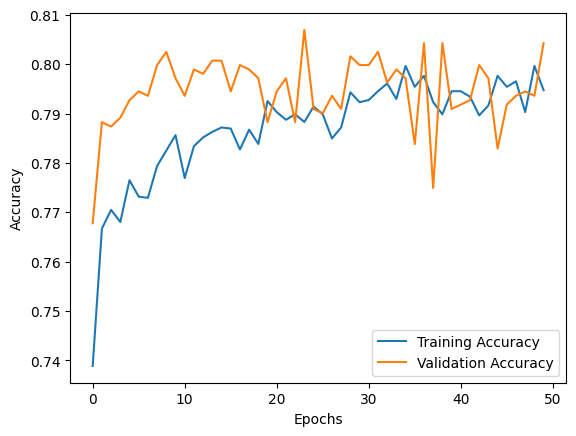

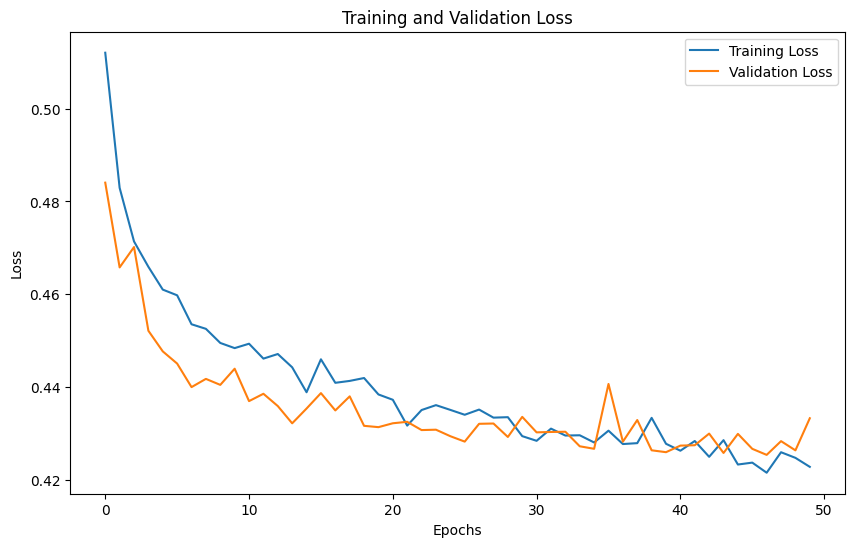

In [61]:
# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Based on the training accuracy and validation accuracy, 34 epochs should be sufficient, thus we retrain the model with both training and validation data as training for 34 epochs.

In [62]:
# Initialize the model
model = Sequential()

# Add 1D Convolutional layers with ReLU activation
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train_val.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))

# Flatten the tensor output by the convolutional layers
model.add(Flatten())

# Add Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_val, y_train_val, validation_data=(X_test, y_test), epochs=34, batch_size=32)

Epoch 1/34
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7381 - loss: 0.5347 - val_accuracy: 0.7544 - val_loss: 0.4717
Epoch 2/34
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7766 - loss: 0.4702 - val_accuracy: 0.7587 - val_loss: 0.4693
Epoch 3/34
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7728 - loss: 0.4638 - val_accuracy: 0.7601 - val_loss: 0.4622
Epoch 4/34
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7837 - loss: 0.4555 - val_accuracy: 0.7637 - val_loss: 0.4569
Epoch 5/34
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7785 - loss: 0.4511 - val_accuracy: 0.7701 - val_loss: 0.4590
Epoch 6/34
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7909 - loss: 0.4479 - val_accuracy: 0.7730 - val_loss: 0.4523
Epoch 7/34
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7890 - loss: 0.4376 - val_accuracy: 0.7630 - val_loss: 0.4521
Epoch 8/34
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7721 - loss: 0.4593 - val_accuracy: 0.

In [64]:
# Predict probabilities
y_pred_proba = model.predict(X_test)
# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Print metrics
print("CNN Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Classification report
print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
conf_mat_df = pd.DataFrame(
    conf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"], 
    index=["Actual Negative", "Actual Positive"]
)
print('\nConfusion Matrix:')
print(conf_mat_df)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
CNN Metrics:
Accuracy: 0.7644
Precision: 0.5660
Recall: 0.4826
F1-score: 0.5210
AUC: 0.8136

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      1032
           1       0.57      0.48      0.52       373

    accuracy                           0.76      1405
   macro avg       0.69      0.67      0.68      1405
weighted avg       0.75      0.76      0.76      1405


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 894                 138
Actual Positive                 193                 180
